# Query data and routing using OpenStreetMaps

[OpenStreetMaps](https://www.openstreetmap.org/) is a free, editable map of the World, which includes information on roads, buildings, points of interest, etc. This session will cover querying data (roads and other features) from OpenStreetMap and how to use the OpenStreetMap road network for routing and accessibility analysis.

We'll heavily rely on the [osmnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) Python package, which facilitates downloading data from OpenStreetMaps and routing along the street network. For routing, __osmnx__ converts the road network to a graph (nodes and edges). __osmnx__ relies on the [networkx](https://networkx.org/) for network analysis.

## Setup

In [48]:
# conda create -n ox -c conda-forge --strict-channel-priority osmnx jupyterlab pandas geopandas pyarrow dask-geopandas dask h3

In [49]:
# ! pip install gadm
# ! pip install h3
# ! pip install geopandas -U
# ! pip install seaborn
# ! pip install rasterstats
# ! pip install rasterio
# ! pip install rioxarray
# ! pip install xvec

In [50]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import h3
from shapely.geometry import Polygon
import os
import seaborn as sns

from gadm import GADMDownloader
downloader = GADMDownloader(version="4.0")

In [51]:
data_dir = "/Users/robmarty/Dropbox/World Bank/Trainings and Code Resources/LAMATA Workshop 2024/Data"

## Load Graph

We first use __osmnx__ to load a graph of a street network for Lagos. We can load using a place name, by specifying a geometry, among other ways.

### Load using place name

In [52]:
# Load graph. If doesn't exist on disk, downloads and saves. 

out_file = os.path.join(data_dir, 'OSM Routing', 'lagos_street_graph.graphml')

if os.path.exists(out_file):
    G = ox.load_graphml(out_file)
else:
    G = ox.graph_from_place('Lagos, Nigeria', network_type='drive')
    ox.save_graphml(G, out_file)

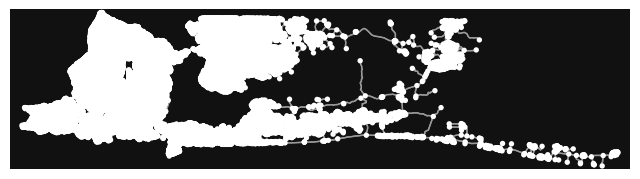

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [53]:
ox.plot_graph(G)

### Load using GeoDataFrame

We use the __gadm__ package to load the administrative boundaries of Nigeria. We grab a polygon of Ikeja and use __osmnx__ to create a road network graph within Ikeja.

In [54]:
nga_gdf = gpd.read_file(os.path.join(data_dir, 'GADM', 'Raw', 'lagos_adm2.geojson'))
ikeja_gdf = nga_gdf[nga_gdf.NAME_2 == "Ikeja"]

<Axes: >

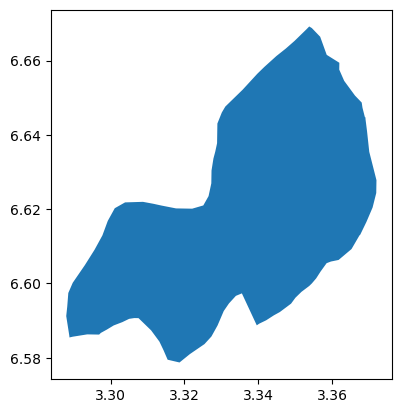

In [55]:
ikeja_gdf.plot()

In [56]:
G_ikeja = ox.graph_from_polygon(ikeja_gdf.geometry.iloc[0], network_type='drive')

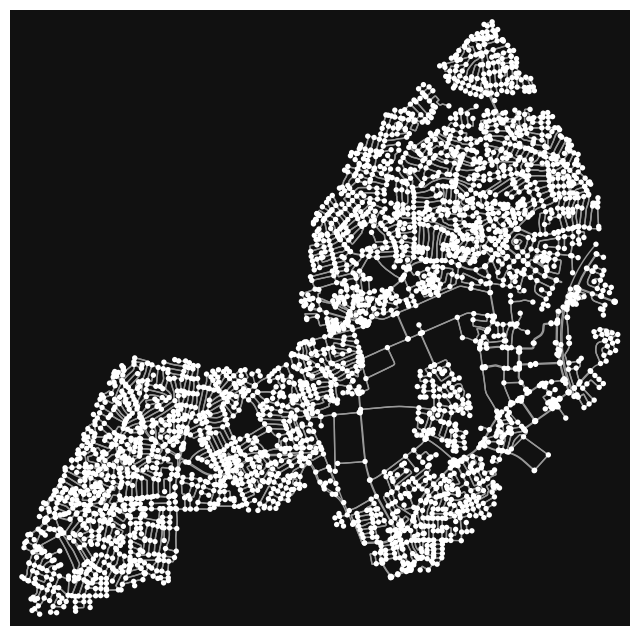

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [57]:
ox.plot_graph(G_ikeja)

### Examining features of graph

In [58]:
G.number_of_nodes()

83626

In [59]:
G.number_of_edges()

207220

In [60]:
G_gdf = ox.convert.graph_to_gdfs(G)

In [61]:
# Nodes
G_gdf[0].head()

y         x  street_count highway                 geometry
osmid                                                                        
3202618256  6.398621  4.266580             3     NaN  POINT (4.26658 6.39862)
3202618257  6.398458  4.269251             4     NaN  POINT (4.26925 6.39846)
3202622665  6.415846  4.093400             3     NaN  POINT (4.09340 6.41585)
3202622669  6.416214  4.090032             3     NaN  POINT (4.09003 6.41621)
3202622940  6.421115  4.065818             3     NaN  POINT (4.06582 6.42112)

In [62]:
# Edges
G_gdf[1].head()

osmid  \
u          v           key                                         
3202618256 10175580642 0                              1112250923   
           3202618257  0                              1113440116   
           10184357068 0                              1113440116   
3202618257 10175580617 0                              1112250921   
           10184357040 0    [1113158587, 1113158588, 1113158589]   

                                 highway  oneway reversed    length  \
u          v           key                                            
3202618256 10175580642 0     residential   False     True   275.259   
           3202618257  0    unclassified   False    False   295.899   
           10184357068 0    unclassified   False     True  1350.114   
3202618257 10175580617 0     residential   False     True   128.581   
           10184357040 0    unclassified   False     True  1787.377   

                                                                     geometry  \
u          v           key                                                      
3202618256 10175580642 0    LINESTRING (4.26658 6.39862, 4.26659 6.39911, ...   
           3202618257  0    LINESTRING (4.26658 6.39862, 4.26690 6.39857, ...   
           10184357068 0    LINESTRING (4.26658 6.39862, 4.26483 6.39891, ...   
3202618257 10175580617 0    LINESTRING (4.26925 6.39846, 4.26959 6.39953, ...   
           10184357040 0    LINESTRING (4.26925 6.39846, 4.26907 6.39811, ...   

                           bridge name lanes  ref maxspeed junction access  \
u          v           key                                                   
3202618256 10175580642 0      NaN  NaN   NaN  NaN      NaN      NaN    NaN   
           3202618257  0      NaN  NaN   NaN  NaN      NaN      NaN    NaN   
           10184357068 0      NaN  NaN   NaN  NaN      NaN      NaN    NaN   
3202618257 10175580617 0      NaN  NaN   NaN  NaN      NaN      NaN    NaN   
           10184357040 0      yes  NaN   NaN  NaN      NaN      NaN    NaN   

                           tunnel width landuse  
u          v           key                       
3202618256 10175580642 0      NaN   NaN     NaN  
           3202618257  0      NaN   NaN     NaN  
           10184357068 0      NaN   NaN     NaN  
3202618257 10175580617 0      NaN   NaN     NaN  
           10184357040 0      NaN   NaN     NaN

#### Exercise: Create another graph
1. Create a graph of the street network for Lagos for __walking__; call this `G_walk`
2. Plot `G_walk`
3. How many nodes and edges does the graph have?

__Hint:__ We used the following code to create a road network for Lagos for the driving network.

```python
G = ox.graph_from_place('Lagos, Nigeria', network_type='drive')
```

## Routing

* Routing minimizes the "cost" to travel from an origin and destination.
* By default, the data has `length`; we could compute the path that would minimize length (ie, shortest path).
* However, in transport we're typically interested in the __fastest__ route between two locations. To determine the fastest route, we need to know the __travel time__ it takes to traverse and edge.

In [63]:
# Add edge speeds (km per hour) to graph as new speed_kph edge attributes.
G = ox.routing.add_edge_speeds(G)

# Calculates free-flow travel time along each edge, 
# based on length and speed_kph attributes.
G = ox.routing.add_edge_travel_times(G)

We define origin and destination locations, then compute the fastest path between the two.

In [64]:
# Define orgin/destination
lamata_node      = ox.nearest_nodes(G, 3.3832, 6.5944) # long, lat
yabacollege_node = ox.nearest_nodes(G, 3.3720, 6.5192) # long, lat 

In [65]:
# Route that minimizes travel time
route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time') 

In [66]:
# Route is just a list of edge IDs
route[:5]

[1473223187, 1473223406, 1473223305, 5616502226, 5606072169]

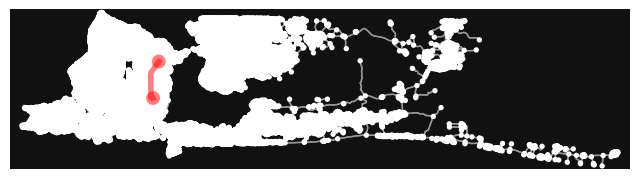

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [67]:
# Plot the route
ox.plot_graph_route(G, route)

In [68]:
# Convert route to geopandas dataframe
route_gdf = ox.routing.route_to_gdf(G, route)

In [69]:
# View
route_gdf.head()

osmid  oneway lanes  ref name        highway  \
u          v          key                                                     
1473223187 1473223406 0    133882114    True   NaN  NaN  NaN        primary   
1473223406 1473223305 0    133882114    True   NaN  NaN  NaN        primary   
1473223305 5616502226 0    133882114    True   NaN  NaN  NaN        primary   
5616502226 5606072169 0    133882114    True   NaN  NaN  NaN        primary   
5606072169 6291361181 0    586759385    True   NaN  NaN  NaN  motorway_link   

                           reversed   length  \
u          v          key                      
1473223187 1473223406 0       False  203.207   
1473223406 1473223305 0       False  329.424   
1473223305 5616502226 0       False   22.086   
5616502226 5606072169 0       False  157.684   
5606072169 6291361181 0       False   22.441   

                                                                    geometry  \
u          v          key                                                      
1473223187 1473223406 0    LINESTRING (3.38366 6.59466, 3.38338 6.59424, ...   
1473223406 1473223305 0    LINESTRING (3.38261 6.59316, 3.38102 6.59099, ...   
1473223305 5616502226 0        LINESTRING (3.38083 6.59078, 3.38071 6.59063)   
5616502226 5606072169 0    LINESTRING (3.38071 6.59063, 3.38062 6.59050, ...   
5606072169 6291361181 0        LINESTRING (3.37989 6.58946, 3.37983 6.58927)   

                           speed_kph  travel_time tunnel junction bridge  
u          v          key                                                 
1473223187 1473223406 0         74.0          9.9    NaN      NaN    NaN  
1473223406 1473223305 0         74.0         16.0    NaN      NaN    NaN  
1473223305 5616502226 0         74.0          1.1    NaN      NaN    NaN  
5616502226 5606072169 0         74.0          7.7    NaN      NaN    NaN  
5606072169 6291361181 0         80.0          1.0    NaN      NaN    NaN

In [70]:
# Length in meters
distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance, 'meters')
print('Total travel time:', travel_time, 'seconds')

Total distance: 9742.187999999998 meters
Total travel time: 462.7 seconds


In [71]:
# Make an interactive map
route_gdf.explore()

### Exercise: Determine the shortest path by travel length instead of travel time. What is the travel distance and travel time of this route?

__Hint:__ Above we used the following code to determine the fastest route. Modify the code to determine the shortest (ie, kilometer distance) route.

```python
route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')

route_gdf = ox.routing.route_to_gdf(G, route)

distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance, 'meters')
print('Total travel time:', travel_time, 'seconds')
```

## Route based on different road network

1. Convert graph to geopandas dataframe to facilitate working with the graph
2. Identify road to change
3. Change `travel_time` for road(s)
4. Recreate graph object
5. Route using new graph

### Change graph

In [72]:
# Convert to geopandas
G_gdf = ox.convert.graph_to_gdfs(G)

In [73]:
# Tupple of length 2
# (nodes, edges)
len(G_gdf)

2

In [74]:
G_nodes_gdf = G_gdf[0]
G_edges_gdf = G_gdf[1]

In [75]:
ik_road = G_edges_gdf[G_edges_gdf.name == "Ikorodu Road"]
ik_road.explore()

In [76]:
# Set road closure
G_edges_gdf.loc[G_edges_gdf['name'] == "Ikorodu Road", 'travel_time'] = 99999999

In [77]:
G_closure = ox.convert.graph_from_gdfs(gdf_nodes = G_nodes_gdf,
                                       gdf_edges = G_edges_gdf)

#### Route using new graph

In [78]:
# Original

route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')

route_gdf = ox.routing.route_to_gdf(G, route)

distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance / 1000, 'kilometers')
print('Total travel time:', travel_time / 60, 'minutes')

Total distance: 9.742187999999999 kilometers
Total travel time: 7.711666666666667 minutes


In [79]:
# Graph with Ikodoru Route Closed

route = ox.shortest_path(G_closure, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')

route_gdf = ox.routing.route_to_gdf(G, route)

distance = route_gdf['length'].sum()
travel_time = route_gdf['travel_time'].sum()

print('Total distance:', distance / 1000, 'kilometers')
print('Total travel time:', travel_time / 60, 'minutes')

Total distance: 11.940184999999998 kilometers
Total travel time: 11.54 minutes


In [80]:
route_gdf.explore()

### Exercise: Update graph assuming Ikorodu Road improved

Before we assumed that Ikorodu Road closed. Now, assume that Ikorodu Road improved (e.g, some intervention was done to reduce congestion). Now, vehicles travel 10 km/h faster than before. 

Assuming this change to Ikorodu Road, recalculate travel time. 

__Hint 1:__ The below code was used to change the graph assuming a road closure. 

```python
G_gdf = ox.convert.graph_to_gdfs(G)

G_nodes_gdf = G_gdf[0]
G_edges_gdf = G_gdf[1]

G_edges_gdf.loc[G_edges_gdf['name'] == "Ikorodu Road", 'travel_time'] = 99999999

G_closure = ox.convert.graph_from_gdfs(gdf_nodes = G_nodes_gdf,
                                       gdf_edges = G_edges_gdf)
```

__Hint 2:__ The following code uses the `length` and `speed_kph` variables to determine travel time along a route. First, we need to change the speed of Ikorodu Road, then we can use this function to determine travel time. 

```python
G = ox.routing.add_edge_travel_times(G)
```

__Hint 3:__ We have used the following code to determine the shortest path along network `G` between two nodes.

```python
route = ox.shortest_path(G, 
                         lamata_node, 
                         yabacollege_node, 
                         weight='travel_time')
 ```                        

In [81]:
# CODE HERE

## Network Statistics

A number of statistics can be generated for networks. See [this guide](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#metrics-available-in-networkx) for a summary of different indicators. Here, we summarize calculating one metric: betweenness centrality. 

### Betweenness Centrality
1. Between each node, compute the shortest path
2. Determine the number (proportion) of shortest paths that pass through each node

In [82]:
bc = nx.betweenness_centrality(G_ikeja)

In [83]:
# The node with the highest betweenness centrality
# 41% of shortest paths go through this node
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(7324468009, 0.41114816334499804)

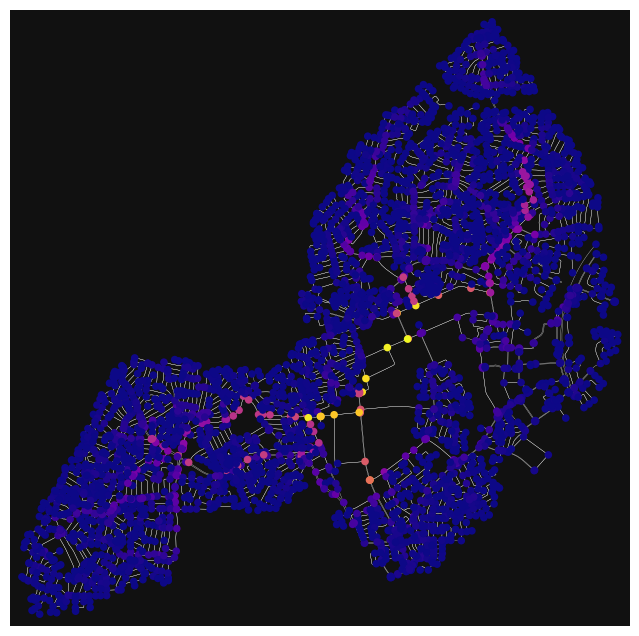

In [84]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G_ikeja, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G_ikeja, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G_ikeja,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

## Query Points of Interest

The __oxmnx__ package allows querying OpenStreetMap information beyond roads. Here we show an example querying [bus stops](https://www.openstreetmap.org/node/6967079716)

In [85]:
bus_gdf = ox.features.features_from_place(query = "Lagos, Nigeria",
                                tags = {'highway': 'bus_stop',
                                       'amenity': 'bus_station'})

In [86]:
bus_gdf.shape

(158, 30)

In [87]:
bus_gdf.head()

highway     name                 geometry  bus  \
element_type osmid                                                         
node         3095002640  bus_stop  Chevron  POINT (3.52971 6.44103)  NaN   
             3095002719  bus_stop  Chevron  POINT (3.53202 6.44171)  NaN   
             5194462808  bus_stop  Chevron  POINT (3.52983 6.44072)  NaN   
             5194462809  bus_stop  Chevron  POINT (3.53191 6.44192)  NaN   
             5246332118  bus_stop      NaN  POINT (3.61753 6.47508)  yes   

                        public_transport addr:country operator shelter note  \
element_type osmid                                                            
node         3095002640              NaN          NaN      NaN     NaN  NaN   
             3095002719              NaN          NaN      NaN     NaN  NaN   
             5194462808              NaN          NaN      NaN     NaN  NaN   
             5194462809              NaN          NaN      NaN     NaN  NaN   
             5246332118         platform          NaN      NaN     NaN  NaN   

                        amenity  ... departures_board foot motor_vehicle  \
element_type osmid               ...                                       
node         3095002640     NaN  ...              NaN  NaN           NaN   
             3095002719     NaN  ...              NaN  NaN           NaN   
             5194462808     NaN  ...              NaN  NaN           NaN   
             5194462809     NaN  ...              NaN  NaN           NaN   
             5246332118     NaN  ...              NaN  NaN           NaN   

                        surface bus_stop:category building building:levels  \
element_type osmid                                                           
node         3095002640     NaN               NaN      NaN             NaN   
             3095002719     NaN               NaN      NaN             NaN   
             5194462808     NaN               NaN      NaN             NaN   
             5194462809     NaN               NaN      NaN             NaN   
             5246332118     NaN               NaN      NaN             NaN   

                        description wikidata wikipedia  
element_type osmid                                      
node         3095002640         NaN      NaN       NaN  
             3095002719         NaN      NaN       NaN  
             5194462808         NaN      NaN       NaN  
             5194462809         NaN      NaN       NaN  
             5246332118         NaN      NaN       NaN  

[5 rows x 30 columns]

In [88]:
bus_gdf.explore()

### Exercise: Query schools from OpenStreetMaps. How many schools are there?

__Hint 1:__ [This webpage](https://wiki.openstreetmap.org/wiki/Key:amenity) shows different amenities that can be queried from OpenStreetMap. One `amenity` key is `school`.

__Hint 2:__ We used the below code to query bus stops and stations.
```python
bus_gdf = ox.features.features_from_place(query = "Lagos, Nigeria",
                                tags = {'highway': 'bus_stop',
                                       'amenity': 'bus_station'})
```

## Accessibility to bus stops

In this section, we show accessibility to bus stops across Lagos. The end goal is to create a map of Lagos that shows which locations have smaller/larger travel times to reach a bus stop.

### 1. Add nearest node to bus stops

In [89]:
def det_nearest_node(row):
    n_node = ox.nearest_nodes(G, row['longitude'], row['latitude'])
    return(n_node)

In [90]:
bus_gdf['centroid'] = bus_gdf.centroid

bus_gdf['longitude'] = bus_gdf['centroid'].x
bus_gdf['latitude'] = bus_gdf['centroid'].y

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_75864/387089161.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bus_gdf['centroid'] = bus_gdf.centroid


In [91]:
bus_gdf['node'] = bus_gdf.apply(det_nearest_node, axis=1)

In [92]:
bus_gdf.head()

highway     name                 geometry  bus  \
element_type osmid                                                         
node         3095002640  bus_stop  Chevron  POINT (3.52971 6.44103)  NaN   
             3095002719  bus_stop  Chevron  POINT (3.53202 6.44171)  NaN   
             5194462808  bus_stop  Chevron  POINT (3.52983 6.44072)  NaN   
             5194462809  bus_stop  Chevron  POINT (3.53191 6.44192)  NaN   
             5246332118  bus_stop      NaN  POINT (3.61753 6.47508)  yes   

                        public_transport addr:country operator shelter note  \
element_type osmid                                                            
node         3095002640              NaN          NaN      NaN     NaN  NaN   
             3095002719              NaN          NaN      NaN     NaN  NaN   
             5194462808              NaN          NaN      NaN     NaN  NaN   
             5194462809              NaN          NaN      NaN     NaN  NaN   
             5246332118         platform          NaN      NaN     NaN  NaN   

                        amenity  ... bus_stop:category building  \
element_type osmid               ...                              
node         3095002640     NaN  ...               NaN      NaN   
             3095002719     NaN  ...               NaN      NaN   
             5194462808     NaN  ...               NaN      NaN   
             5194462809     NaN  ...               NaN      NaN   
             5246332118     NaN  ...               NaN      NaN   

                        building:levels description wikidata wikipedia  \
element_type osmid                                                       
node         3095002640             NaN         NaN      NaN       NaN   
             3095002719             NaN         NaN      NaN       NaN   
             5194462808             NaN         NaN      NaN       NaN   
             5194462809             NaN         NaN      NaN       NaN   
             5246332118             NaN         NaN      NaN       NaN   

                                        centroid longitude  latitude  \
element_type osmid                                                     
node         3095002640  POINT (3.52971 6.44103)  3.529713  6.441032   
             3095002719  POINT (3.53202 6.44171)  3.532017  6.441715   
             5194462808  POINT (3.52983 6.44072)  3.529829  6.440718   
             5194462809  POINT (3.53191 6.44192)  3.531910  6.441922   
             5246332118  POINT (3.61753 6.47508)  3.617531  6.475082   

                               node  
element_type osmid                   
node         3095002640  5184438466  
             3095002719  1832697416  
             5194462808  5184438466  
             5194462809  1832697416  
             5246332118  5246332118  

[5 rows x 34 columns]

### 2. Make hexagons that cover Lagos

We'll determine accessibility from each hexagon to bus stops

In [93]:
nga_gdf = downloader.get_shape_data_by_country_name(country_name="Nigeria", ad_level=1)
lagos_gdf = nga_gdf[nga_gdf.NAME_1 == "Lagos"]

In [94]:
# Convert from multipolygon to polygon
lagos_gdf = lagos_gdf.explode()

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_75864/4189579028.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  lagos_gdf = lagos_gdf.explode()


In [95]:
lagos_hexagons = h3.polyfill(lagos_gdf.geometry.iloc[0].__geo_interface__, 7)

In [96]:
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id))

all_polys = gpd.GeoSeries(list(map(polygonise, lagos_hexagons)), \
                                      index=lagos_hexagons, \
                                      crs="EPSG:4326" \
                                     )

lagos_hex_gdf = gpd.GeoDataFrame(geometry=all_polys)

In [97]:
lagos_hex_gdf.explore()

#### Lets remove hexagons that cover water

In [98]:
water_gdf = ox.features.features_from_place(query = "Lagos, Nigeria",
                                tags = {'natural': 'water'})

In [99]:
water_gdf.explore()

In [100]:
water_gdf = water_gdf[water_gdf.name.isin(['Lagos Lagoon', 'Epe Lagoon' ,'Lekki Lagoon'])]
water_gdf.explore()

In [101]:
lagos_hex_gdf['inter_water'] = lagos_hex_gdf.geometry.apply(lambda hex_geom: water_gdf.geometry.intersects(hex_geom).any())

lagos_hex_gdf = lagos_hex_gdf[lagos_hex_gdf.inter_water == False]

lagos_hex_gdf.explore()

### 3. Add node for each hexagon

In [102]:
lagos_hex_gdf['centroid'] = lagos_hex_gdf.centroid

lagos_hex_gdf['longitude'] = lagos_hex_gdf['centroid'].x
lagos_hex_gdf['latitude'] = lagos_hex_gdf['centroid'].y

/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/ipykernel_75864/2753656803.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lagos_hex_gdf['centroid'] = lagos_hex_gdf.centroid


In [103]:
lagos_hex_gdf['node'] = lagos_hex_gdf.apply(det_nearest_node, axis=1)

### 4. Determine travel time from each hexagon to nearest bus station

For each hexagon, one approach would be to determine the travel time to all bus stations and take the minimum travel time. However, doing this for all hexagons would take a long time.

We know that bus stations very far away (straight line distance) also have long travel times. Consequently, we find the 10 closest (straight line distance) bus stops and calculate the travel time to each of those---and take the minimum value.

In [104]:
def det_travel_time(row, hex_node, G):
    '''
    Determine travel time between an origin an destination.

    Args:
        row: Row of a pandas dataframe of bus stops that has a "node" variable
        hex_node: Node of hexagon
        G: Graph

    Output:
        Travel time
    '''
    
    route = ox.shortest_path(G, 
                             hex_node, 
                             row.node, 
                             weight='travel_time')

    route_gdf = ox.routing.route_to_gdf(G, route)
    
    travel_time = route_gdf['travel_time'].sum()

    return travel_time

In [105]:
def min_tt_hex_busstops(row, bus_gdf, G):
    '''
    Determine the minimum travel time between each hexagon and bus stops

    Args:
        row: Row of hexagon dataframe that has a "node" variable
        bus_gdf: Bus geopandas dataframe
        G: Graph
    '''

    # Compute straight line distance from bus stops to hexagon i
    bus_gdf['dist_to_hex_i'] = bus_gdf.geometry.apply(lambda g: row.geometry.distance(g))

    # Sort dataframe by distance and take the 10 closest bus stops
    bus_gdf = bus_gdf.sort_values(by='dist_to_hex_i')
    bus_closest_gdf = bus_gdf.iloc[0:2]

    # Compute travel times and determine minimum travel time
    travel_times = bus_closest_gdf.apply(det_travel_time, 
                                     axis = 1, 
                                     args = (row.node, G, ))

    travel_times_min = min(travel_times)
    
    return travel_times_min

In [106]:
%time tt_min = lagos_hex_gdf.iloc[0:10].apply(min_tt_hex_busstops, axis=1, args=(bus_gdf, G, ))

CPU times: user 4.39 s, sys: 27 ms, total: 4.42 s
Wall time: 4.45 s


In [107]:
%time lagos_hex_gdf['tt_nearest_busstop'] = lagos_hex_gdf.apply(min_tt_hex_busstops, axis=1, args=(bus_gdf, G, ))

CPU times: user 4min 14s, sys: 1.17 s, total: 4min 15s
Wall time: 4min 17s


<Axes: xlabel='tt_nearest_busstop_min', ylabel='Count'>

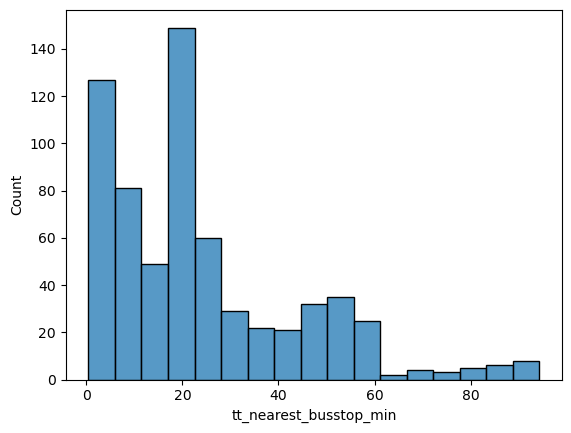

In [108]:
lagos_hex_gdf['tt_nearest_busstop_min'] = lagos_hex_gdf['tt_nearest_busstop'] / 60

sns.histplot(data=lagos_hex_gdf, x="tt_nearest_busstop_min")

In [109]:
lagos_hex_gdf.explore(column = "tt_nearest_busstop_min")

In [110]:
# Before exporting, need to drop one of the geometry columns
lagos_hex_gdf = lagos_hex_gdf.drop(columns=['centroid'])

In [115]:
export = False

if export:
    lagos_hex_gdf.to_file(os.path.join(data_dir, "OSM Routing", "brt_access_hexs.geojson"))